# Hands-on 3: Kmeans Notebook (Tutorial)







---

Por: **Cesar Balam Espinosa Nuñez**

Para la materia: **Clasificación inteligente de datos**



---



## 1 Fundamentos de la Técnica

K-Means es un algoritmo de clustering (agrupamiento) no supervisado. Su objetivo principal es particionar un conjunto de n observaciones en k clusters (grupos) distintos.

El algoritmo funciona de manera iterativa para asignar cada punto de datos al cluster cuyo "centroide" (la media de los puntos del cluster) esté más cercano.

El proceso general es:

* Inicialización: Se eligen k puntos aleatorios como los centroides iniciales.

* Asignación: Cada punto del dataset se asigna al cluster del centroide más cercano (generalmente usando la distancia euclidiana).

* Actualización: Se recalculan los centroides de cada cluster tomando la media de todos los puntos asignados a él.

* Convergencia: Los pasos 2 y 3 se repiten hasta que los centroides dejan de moverse significativamente o se alcanza un número máximo de iteraciones.



---



## 2 Modelo Matemático

Sea $$X = \{x_1, x_2, ..., x_n\} \subset \mathbb{R}^d$$ un conjunto de datos y $$\mu_1, \mu_2, ..., \mu_k$$ los centroides de los $k$ clústeres.  
El objetivo de **K-Means** es minimizar la **suma de las distancias cuadradas dentro de cada clúster** (*Within-Cluster Sum of Squares*, WCSS):

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

donde:
* **$k$**: número de clústeres.
* **$C_i$**: conjunto de puntos asignados al clúster $i$.
* **$\mu_i$**: centroide del clúster $i$.

El algoritmo alterna entre dos pasos fundamentales:

1. **Asignación:** asignar cada punto $x$ al clúster cuyo centroide $\mu_i$ esté más cercano.  
2. **Actualización:** recalcular cada centroide $\mu_i$ como la media de los puntos pertenecientes a su clúster.

El proceso se repite hasta la **convergencia**, es decir, cuando las asignaciones ya no cambian o la variación de la función objetivo $J$ es mínima.




---



## 3. Descripción de la librería y funciones usadas
- **numpy:** para operaciones matemáticas y manejo de arreglos.
- **pandas:** para manipular datasets como tablas.
- **seaborn:** para visualizaciones especificas.
- **matplotlib:** para visualización de datos.
- **scikit-learn** (**sklearn**):
  - `datasets`: Módulo que proporciona colecciones de datos de ejemplo listos para usar como el dataset Iris.

  - `cluster.KMeans`: La clase específica dentro del submódulo cluster que implementa el algoritmo K-Means.

  - `metrics.cluster` (aliased as cluster_metrics): un submódulo para métricas específicas de agrupamiento (ej. Homogeneidad, Completitud, V-Measure, etc.).

  - `confusion_matrix`: para crear la matriz de confusión que muestra resultados de una clasificacion, en este caso solo para fines ilustrativos despues de predecir.

  - `accuracy_score`: para calcular la precisión global del modelo.

  - `metrics.cluster.contingency_matrix`: Función específica dentro de sklearn.metrics.cluster que calcula la matriz de contingencia. Es la herramienta clave que usamos para establecer el puente entre las etiquetas verdaderas y los números de cluster arbitrarios antes de calcular el Accuracy o la Matriz de Confusión.



---



## 4 Pipeline

### 4.1 Preprocessing

In [149]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import cluster as cluster_metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics.cluster import contingency_matrix

# Cargar el dataset iris
iris = datasets.load_iris()

# Dividir los datos en columnas y objetivo
X = iris.data
Y = iris.target

feature_names = iris.feature_names

# Guardar el dataset en un dataframe
df = pd.DataFrame(X, columns=feature_names)
df['target'] = Y
df['target_name'] = [iris.target_names[i] for i in Y]

# Estadísticas descriptivas
desc = df.describe()
desc_transposed = desc.T
desc_transposed['std'] = df.std(numeric_only=True)

# Mostrar estadísticas
print('\nEstadísticas descriptivas:\n')
display(desc_transposed)

# Distribución de clases
print("\nDistribución de Clases:")
print(df['target_name'].value_counts())


Estadísticas descriptivas:



,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5
target,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0



Distribución de Clases:
target_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


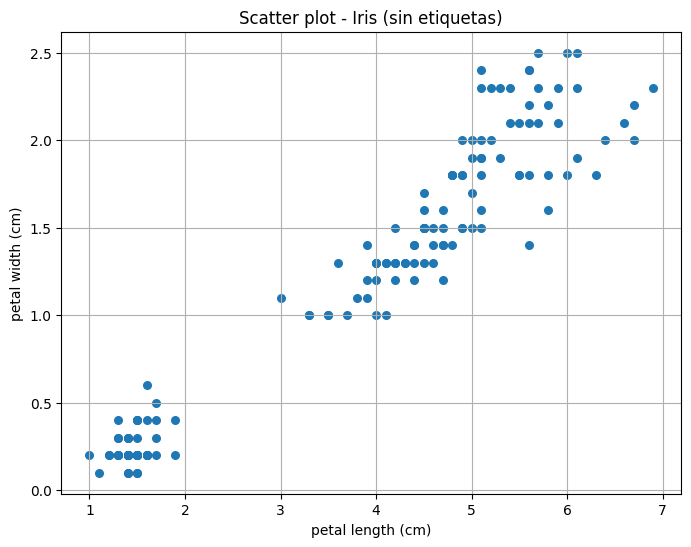

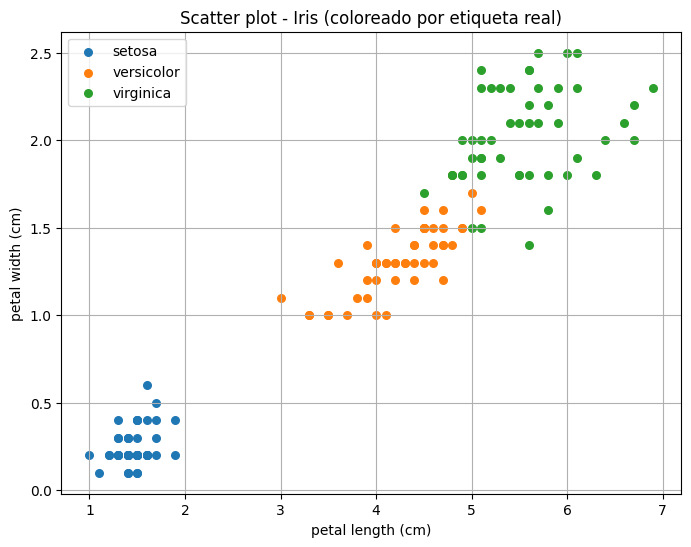

In [150]:
# Gráfico de dispersión sin etiquetas
plt.figure(figsize=(8,6))
plt.scatter(X[:,2], X[:,3], s=30)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title('Scatter plot - Iris (sin etiquetas)')
plt.grid(True)
plt.show()

# Scatter coloreado por etiqueta real
plt.figure(figsize=(8,6))
for lab in np.unique(Y):
    mask = (Y == lab)
    plt.scatter(X[mask,2], X[mask,3], label=iris.target_names[lab], s=30)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title('Scatter plot - Iris (coloreado por etiqueta real)')
plt.legend()
plt.grid(True)
plt.show()


### 4.2 Model Training

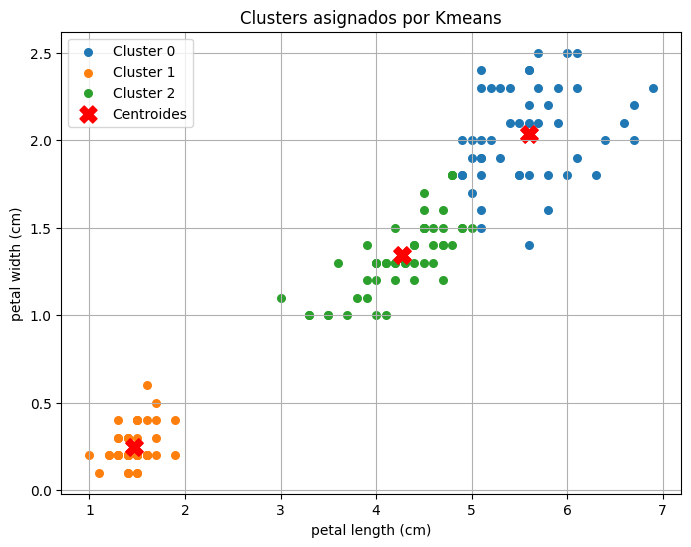

In [151]:
# Centroides en base a las clases que conocemos (setosa, versicolor, virginica)
k = 3

# Modelo
model = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)

# Uso de las caracteristicas de los petalos
# Escojo estas porque son las que resultan en una mejor separacion de las agrupaciones, es para que el resultado se vea mejor y mas claro
X = X[:, 2:4] # Si se corre esta celda individual se rompe porque se toman caracteristicas de indices que ya no existen (2:4) mejor corre todas las celdas
model.fit(X)

# Visualizacion con los centroides

# Agregar los datos a la visualizacion con su clase de centroide asignada
labels = model.labels_
plt.figure(figsize=(8,6))
for lab in np.unique(labels):
    mask = (labels == lab)
    plt.scatter(X[mask,0], X[mask,1], s=30, label=f'Cluster {lab}')

# Agregar los centroides a la visualizacion
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='X', s=150, color='red', label='Centroides')
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='X', s=150, color='red')
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title('Clusters asignados por Kmeans')
plt.legend()
plt.grid(True)
plt.show()



### 4.3 Prediction

Patrón de entrada: [4.8, 1.6]
Cluster K-Means asignado: 2
Clase Predicha (Mapeada): versicolor


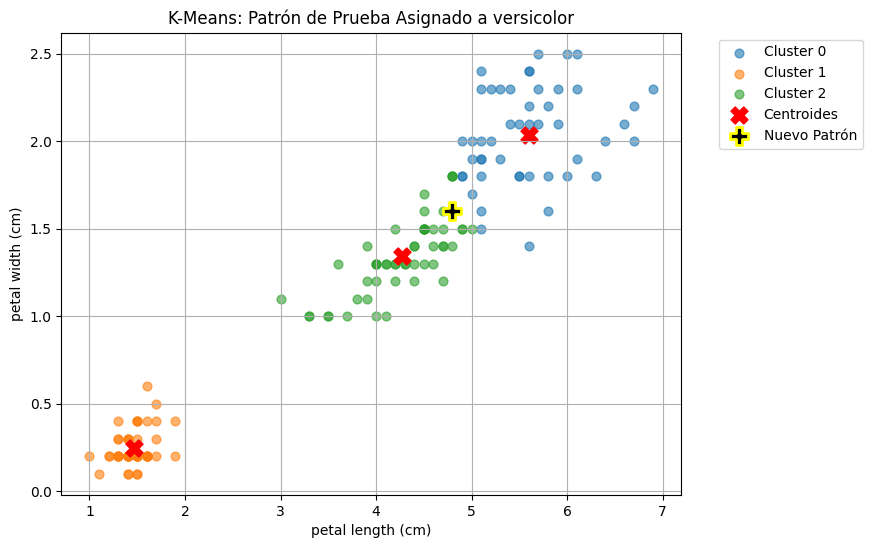

np.str_('versicolor')

In [152]:
def predict_pattern_with_viz(pattern):
    """
    Recibe un patrón de datos, predice su cluster,
    devuelve la etiqueta real mapeada y visualiza el punto en el gráfico de clusters.
    """
    # Preparación del patrón
    arr = np.array(pattern).reshape(1, -1)

    # Obtener el cluster predicho (arbitrario)
    cluster_predicho = model.predict(arr)[0]

    # Mapear el cluster arbitrario a la etiqueta real
    etiqueta_mapeada_index = cluster_to_label_simple.get(cluster_predicho)

    # Obtener el nombre de la etiqueta
    nombre_etiqueta = iris.target_names[etiqueta_mapeada_index] if etiqueta_mapeada_index is not None else "Desconocido"

    print(f"Patrón de entrada: {pattern}")
    print(f"Cluster K-Means asignado: {int(cluster_predicho)}")
    print(f"Clase Predicha (Mapeada): {nombre_etiqueta}")

    # Visualizacion
    plt.figure(figsize=(8,6))

    # Dibujar los clusters existentes
    for lab in np.unique(labels):
        mask = (labels == lab)
        plt.scatter(X[mask,0], X[mask,1], s=40, alpha=0.6, label=f'Cluster {lab}')

    # Dibujar los centroides
    plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='X', s=150, color='red', label='Centroides')

    # Dibujar el punto nuevo de prediccion
    plt.scatter(arr[:, 0], arr[:, 1],
                marker='P', # Marcador para destacarlo
                s=150,
                color='black',
                edgecolor='yellow',
                linewidth=2,
                label=f'Nuevo Patrón')

    plt.xlabel(feature_names[2])
    plt.ylabel(feature_names[3])
    plt.title(f'K-Means: Patrón de Prueba Asignado a {nombre_etiqueta}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

    return nombre_etiqueta

# Ejemplo
new_pattern = [4.8, 1.6]  # petal length, petal width
predict_pattern_with_viz(new_pattern)

### 4.4 Model Evaluation


 Mapeo Derivado (argmax) de Cluster → Etiqueta Real:
  Cluster 0 → virginica
  Cluster 1 → setosa
  Cluster 2 → versicolor

Evaluacion final del modelo:
Exactitud: 0.9600


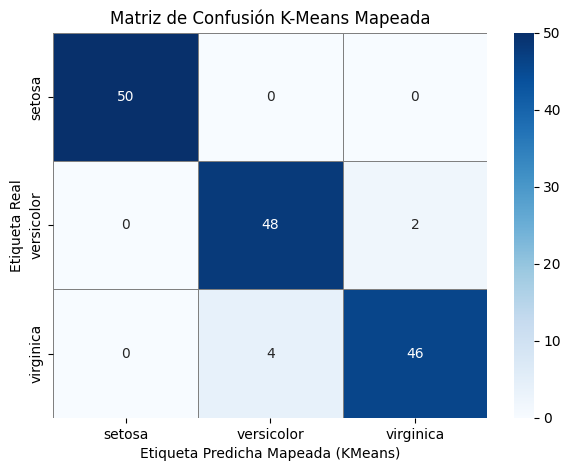


 Interpretación Breve:
- Accuracy: El 96.00% de las muestras fueron correctamente agrupadas y asignadas a la clase real después del mapeo.
- Matriz de Confusión: Muestra los aciertos en la diagonal principal. Los valores fuera de la diagonal son los errores de agrupamiento del modelo.


In [153]:
# Obtencion de etiquetas de cluster
cluster_labels = model.labels_

# Obtencion de matriz de contingencia
# Filas = Etiquetas Verdaderas (Y)
# Columnas = Clusters Asignados (cluster_labels)
cont_matrix = contingency_matrix(Y, cluster_labels)


# Mapeo simple por maxima coincidencia (argmax)
cluster_to_label_simple = {}
for cluster_id in range(k):
    # Encontramos la fila (etiqueta real) con el máximo conteo en la columna del cluster
    # np.argmax devuelve el índice de la etiqueta real que más coincidió con ese cluster
    true_label_index = np.argmax(cont_matrix[:, cluster_id])
    cluster_to_label_simple[cluster_id] = true_label_index

print("\n Mapeo Derivado (argmax) de Cluster → Etiqueta Real:")
for cluster_id, label_index in cluster_to_label_simple.items():
    print(f"  Cluster {cluster_id} → {iris.target_names[label_index]}")


# Aplicamos el mapeo derivado a todas las etiquetas de cluster del modelo
mapped_labels = np.array([cluster_to_label_simple[label] for label in cluster_labels])


# Calculo de metricas finales
cm = confusion_matrix(Y, mapped_labels)
acc = accuracy_score(Y, mapped_labels)

print("\nEvaluacion final del modelo:")
print(f"Exactitud: {acc:.4f}")

# Visualizacion de la matriz de confusion
class_names = iris.target_names

plt.figure(figsize=(7, 5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            linewidths=.5,
            linecolor='gray')
plt.xlabel("Etiqueta Predicha Mapeada (KMeans)")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión K-Means Mapeada")
plt.show()


# Breve explicación de los resultados
print("\n Interpretación Breve:")
print(f"- Accuracy: El {acc*100:.2f}% de las muestras fueron correctamente agrupadas y asignadas a la clase real después del mapeo.")
print("- Matriz de Confusión: Muestra los aciertos en la diagonal principal. Los valores fuera de la diagonal son los errores de agrupamiento del modelo.")

## 5 Referencias bibliográficas

- Na8. (2018, March 12). K-Means con Python paso a paso | Aprende Machine Learning. Aprendemachinelearning.com. https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/

- Kavlakoglu, E., & Winland, V. (2024, June 26). K-Means Clustering. Ibm.com. https://www.ibm.com/mx-es/think/topics/k-means-clustering

- Arvai, K. (2020, July 20). K-Means Clustering in Python: A Practical Guide. Realpython.com; Real Python. https://realpython.com/k-means-clustering-python/

- KMeans. (2025). Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html